In [ ]:
import networkx as nx 
import os
import pickle
from graph_reader import GraphManager
from simulation_graph import SimulationGraph
import osmnx as ox

reader = GraphManager()

filters = '["highway"~"motorway|trunk|primary"]'

graph = SimulationGraph.from_osmnx("Polska", custom_filter=filters)


reader.save_pickle_file("poland_motorway_trunk_primary.pkl", graph)
ox.plot_graph(graph)

In [ ]:
reader.save_pickle_file("poland_motorway_trunk.pkl", graph)

print(len(graph.nodes()))
print(len(graph.edges()))

In [1]:
import sys, os, math
import networkx as nx
import pandas as pd
from graph_reader import GraphManager


project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

import models.agents.exporter_agent as exp_mod
print("ExporterAgent module file:", exp_mod.__file__)
print("ExporterAgent ma metodę find_cheapest_path:", hasattr(exp_mod.ExporterAgent, "find_cheapest_path"))

from simulation_graph import SimulationGraph

reader = GraphManager()
try:
    graph = reader.load_pickle_graph("poland_motorway_trunk_primary.pkl")
    print("✅ Załadowano SimulationGraph z pliku poland_motorway_trunk_primary.pkl")
except Exception as e:
    print("❌ Błąd wczytywania grafu:", e)
    graph = None



major_cities = {
    "Warszawa": (52.23, 21.01),
    "Kraków": (50.06, 19.94),
    "Łódź": (51.77, 19.46),
    "Wrocław": (51.11, 17.03),
    "Poznań": (52.41, 16.93),
    "Gdańsk": (54.35, 18.65),
    "Szczecin": (53.43, 14.55),
    "Lublin": (51.25, 22.57),
    "Katowice": (50.26, 19.03),
    "Białystok": (53.13, 23.15),
    "Rzeszów": (50.04, 22.00),
    "Olsztyn": (53.78, 20.49),
    "Toruń": (53.01, 18.60),
    "Bydgoszcz": (53.12, 18.01),
    "Kielce": (50.87, 20.63),
    "Zielona Góra": (51.94, 15.50),
    "Opole": (50.67, 17.93),
    "Gorzów Wielkopolski": (52.73, 15.24),
    "Radom": (51.40, 21.15),
    "Częstochowa": (50.81, 19.12),
}

def haversine_km(lat1, lon1, lat2, lon2):
    """Oblicz dystans Haversine między dwoma punktami."""
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    return 6371 * c



exporter_cities = [
    "Warszawa", "Kraków", "Poznań", "Gdańsk", "Wrocław",
    "Szczecin", "Lublin", "Katowice", "Białystok", "Łódź"
]

exporter_nodes = []
for city in exporter_cities:
    lat_c, lon_c = major_cities[city]
    closest_node = min(
        graph.nodes,
        key=lambda n: haversine_km(lat_c, lon_c, graph.nodes[n].get("y", 0), graph.nodes[n].get("x", 0))
    )
    exporter_nodes.append(closest_node)

print(f"✅ Wybrano {len(exporter_nodes)} eksporterów: {exporter_nodes}")



importer_cities = [
    "Rzeszów", "Olsztyn", "Bydgoszcz", "Toruń", "Kielce",
    "Zielona Góra", "Opole", "Gorzów Wielkopolski", "Radom", "Częstochowa"
]

importer_nodes = []
for city in importer_cities:
    lat_c, lon_c = major_cities[city]
    closest_node = min(
        graph.nodes,
        key=lambda n: haversine_km(lat_c, lon_c, graph.nodes[n].get("y", 0), graph.nodes[n].get("x", 0))
    )
    if closest_node not in exporter_nodes:
        importer_nodes.append(closest_node)

print(f"✅ Wybrano {len(importer_nodes)} importerów: {importer_nodes}")



params = {
    "alpha": 1.0,
    "beta": 1.0,
    "gamma": 0.0,
    "avg_speed_km_per_day": 60.0
}

results = []

graph_undirected = SimulationGraph(default_capacity=graph.default_capacity,
                                   default_price=graph.default_price,
                                   incoming_graph_data=graph)


for i, (exp_node, imp_node) in enumerate(zip(exporter_nodes, importer_nodes), start=1):
    agent = exp_mod.ExporterAgent(agent_id=i, node_id=exp_node)
    try:
        result = agent.find_cheapest_path(graph_undirected, dest_node=imp_node, params=params)
        results.append({
            "agent_id": i,
            "exporter_node": exp_node,
            "importer_node": imp_node,
            **result
        })
        print(f"✅ Agent {i}: {exp_node} → {imp_node} | dystans: {result['total_distance_km']:.2f} km | koszt: {result['estimated_cost']:.2f}")
    except Exception as e:
        print(f"❌ {exp_node} → {imp_node} | błąd: {e}")






df_paths = pd.DataFrame(results)
display(df_paths[["exporter_node", "importer_node", "total_distance_km", "estimated_cost", "estimated_lead_time_days", "method"]])

ExporterAgent module file: c:\Users\kapig\Semestr5\Supply_chain_simulator\models\agents\exporter_agent.py
ExporterAgent ma metodę find_cheapest_path: True
✅ Załadowano SimulationGraph z pliku poland_motorway_trunk_primary.pkl
✅ Wybrano 10 eksporterów: [31917351, 273798747, 2456242846, 301671175, 158719842, 299665034, 4960566619, 323130113, 2725108538, 4864187937]
✅ Wybrano 10 importerów: [568938336, 2628322169, 4406793550, 266869927, 6167064814, 3227987095, 7956106338, 347381591, 1846616301, 3548834403]
✅ Agent 1: 31917351 → 568938336 | dystans: 341.85 km | koszt: 170.93
✅ Agent 2: 273798747 → 2628322169 | dystans: 540.98 km | koszt: 270.49
✅ Agent 3: 2456242846 → 4406793550 | dystans: 141.92 km | koszt: 70.96
✅ Agent 4: 301671175 → 266869927 | dystans: 180.34 km | koszt: 90.17
✅ Agent 5: 158719842 → 6167064814 | dystans: 435.63 km | koszt: 217.81
✅ Agent 6: 299665034 → 3227987095 | dystans: 221.34 km | koszt: 110.67
✅ Agent 7: 4960566619 → 7956106338 | dystans: 513.88 km | koszt: 256.

,exporter_node,importer_node,total_distance_km,estimated_cost,estimated_lead_time_days,method
0,31917351,568938336,341.851078,170.925539,0.135896,graph
1,273798747,2628322169,540.978493,270.489246,0.217652,graph
2,2456242846,4406793550,141.918876,70.959438,0.057096,graph
3,301671175,266869927,180.341991,90.170995,0.084174,graph
4,158719842,6167064814,435.625402,217.812701,0.186354,graph
5,299665034,3227987095,221.340558,110.670279,0.084657,graph
6,4960566619,7956106338,513.877783,256.938891,0.222644,graph
7,323130113,347381591,541.757955,270.878977,0.228550,graph
8,2725108538,1846616301,321.231882,160.615941,0.136352,graph
9,4864187937,3548834403,194.090299,97.045149,0.092462,graph


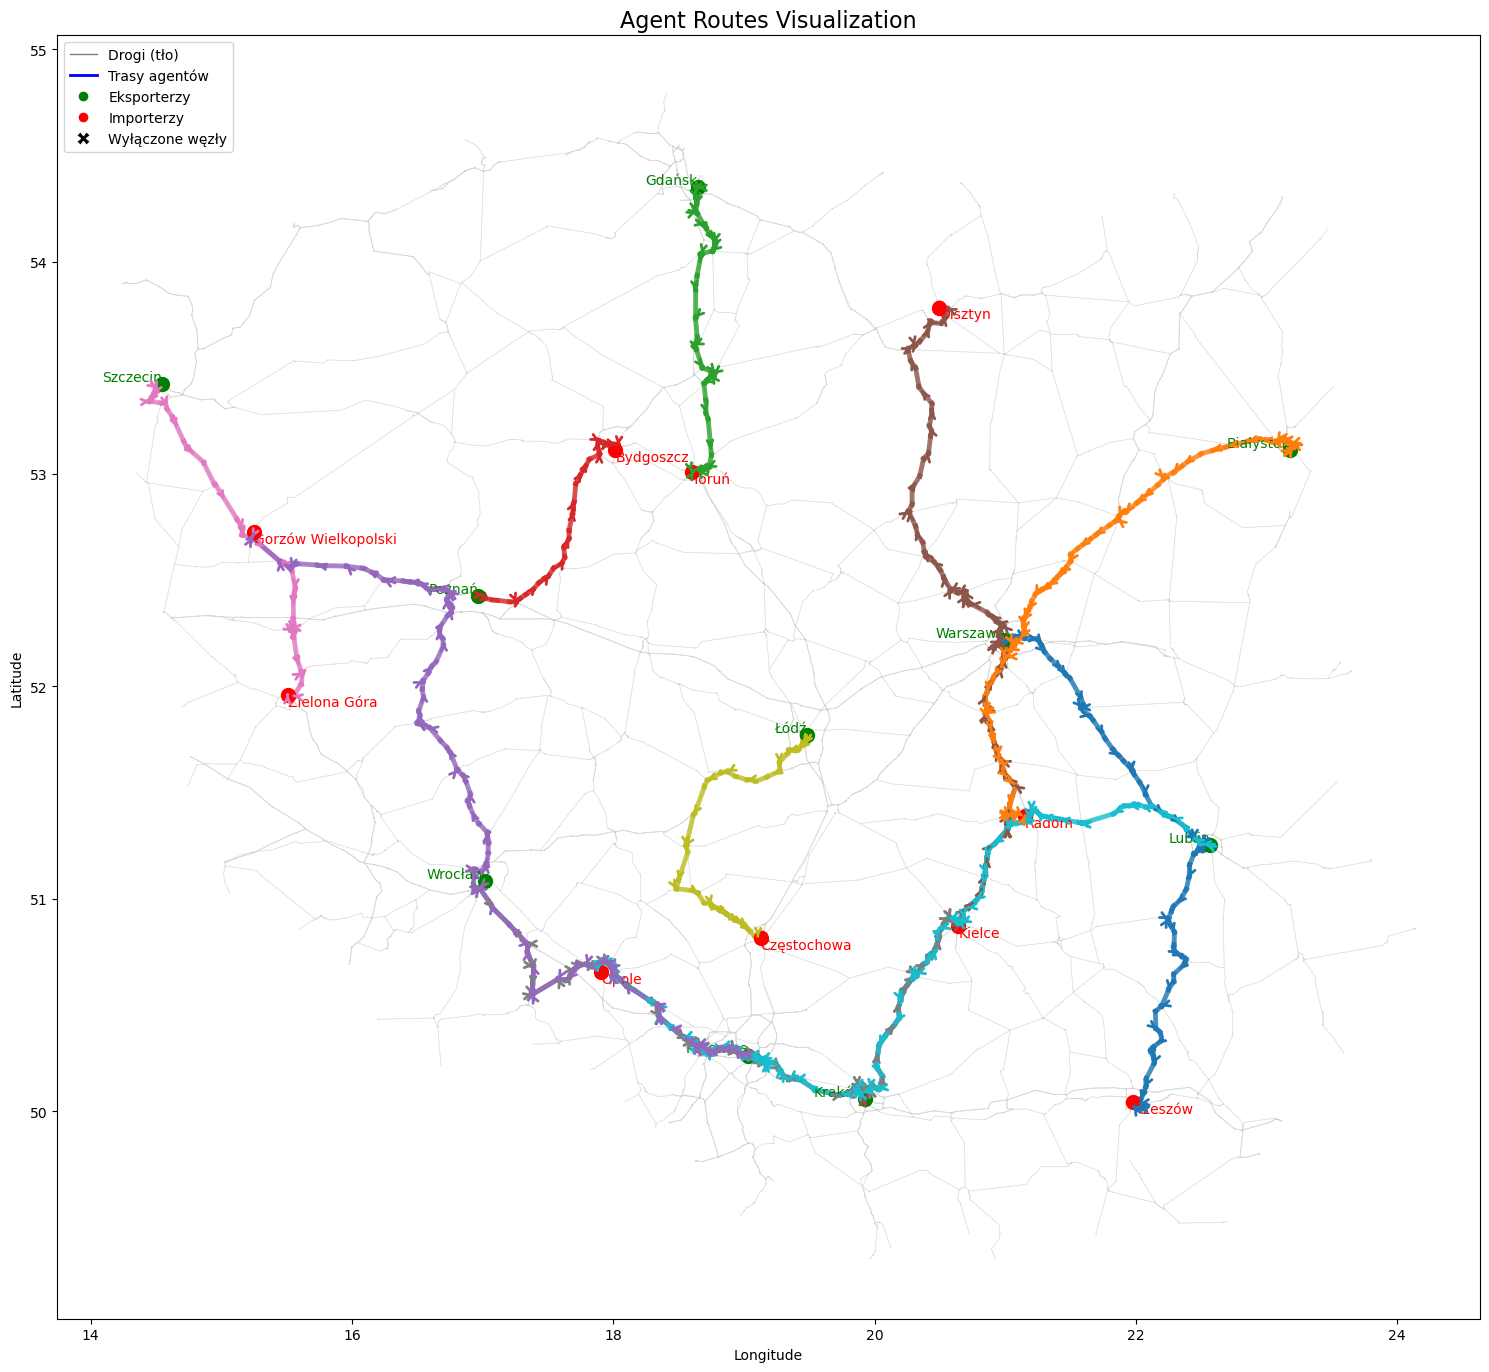

In [2]:
from visualization import plot_agent_routes
 # Zbierz ścieżki agentów (lista list node_id) 
routes = [r['path'] for r in results] 
plot_agent_routes(graph,routes,exporter_nodes,importer_nodes,major_cities=major_cities # słownik {miasto: (lat, lon)} 
)